# Portfolio Construction using MesoSim and Q-API

## Initial setup

In [ ]:
!pip install requests==2.31.0
!pip install matplotlib==3.7.1
!pip install seaborn==0.13.1
!pip install pandas_datareader==0.10.0

In [ ]:
import csv
import json
import time
import multiprocessing
import random
import numpy
import datetime
from io import StringIO

from dateutil.parser import parse as dateparser

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt3
import seaborn as sns
import matplotlib.pyplot as plt

import pandas_datareader.data as web
from IPython.core.display import display, HTML
import requests
from urllib3.util import Retry
from requests.adapters import HTTPAdapter

## Load the user's API Key. ⚠ Never store your key directly in the notebook! ⚠


In [ ]:
from getpass import getpass

MESOSIM_INSTANCE="mesosim.deltaray.io"
Q_API_INSTANCE="q-api.deltaray.io"
API_KEY = getpass('Enter your API Key: ')

Enter your API Key: ··········


## Helper functions to access the APIs

In [ ]:
http_client = requests.Session()

http_retries = Retry(
    total=5,
    backoff_factor=0.1,
    status_forcelist=[500, 502, 503, 504, 520]
)
http_client.mount('https://', HTTPAdapter(max_retries=http_retries, pool_connections=50, pool_maxsize=50))


def get_backtest_navs(mesosim_instance, api_key, backtest_id):
    api_url = f"https://{mesosim_instance}/api/v1"
    headers =  {"Content-Type": "application/json", "Authorization": f"Bearer {api_key}"}
    url = f"{api_url}/backtest/{backtest_id}/navs?id={backtest_id}"
    resp = http_client.get(url, headers=headers)
    resp.raise_for_status()

    nav_values = {"SimTime": [], "NAV": []}
    nav_csv_reader = csv.DictReader(resp.text.split("\n"))
    for row in nav_csv_reader:
      nav_values["SimTime"].append(dateparser(row["Sim Time"]))
      nav_values["NAV"].append(float(row["NAV"]))

    return nav_values

def _q_api_df_to_csv(df, colname):
  result_df = df.resample('D').ffill()      # Have one reading per day
  result_df = result_df[[colname]]          # Keep sum only
  result_df.rename(columns={colname: "StrategyNAV"}, inplace=True)
  result_df.index.rename('DateTime', inplace=True)


  df_spx = web.DataReader(
        '^SPX', 'stooq',
        result_df.index[0].date(), result_df.index[-1].date())
  result_df["BenchmarkPrice"] = df_spx["Close"]

  result_df.dropna(inplace=True)

  result_csv = result_df.to_csv()
  return result_csv


def display_tearsheet(q_api_instance, api_key, df, colname):
  my_csv = _q_api_df_to_csv(df, colname)
  url = f"https://{q_api_instance}/quantstats/v1/tearsheet-from-csv"
  resp = http_client.post(url, data=my_csv,
                          headers = {'Content-Type': 'text/plain'})
  resp.raise_for_status()
  display(HTML(resp.content.decode('utf-8')))

def get_metrics(q_api_instance, api_key, df, colname):
  my_csv = _q_api_df_to_csv(df, colname)
  url = f"https://{q_api_instance}/quantstats/v1/metrics-from-csv"
  resp = http_client.post(url, data=my_csv,
                          headers = {'Content-Type': 'text/plain'})
  resp.raise_for_status()
  return resp.json()

def walkforward_metrics(q_api_instance, api_key, df, optMode, topAlloc, window):
  df_copy = pd.DataFrame(df)
  df_copy.index.rename('DateTime', inplace=True)
  my_csv = df_copy.to_csv()
  url = f"https://{q_api_instance}/portfolio-optimizer/v1/walkforward-portfolio?mode={optMode}&topAlloc={topAlloc}&windowSize={window}"
  resp = http_client.post(url, data=my_csv,
                          headers = {'Content-Type': 'text/plain'})
  resp.raise_for_status()
  result_df = pd.read_csv(StringIO(resp.content.decode('utf-8')), parse_dates=True, index_col='DateTime')
  metrics = get_metrics(q_api_instance, api_key, result_df, 'portfolio')
  return metrics

def walkforward_tearsheet(q_api_instance, api_key, df, optMode, topAlloc, window):
  df_copy = pd.DataFrame(df)
  df_copy.index.rename('DateTime', inplace=True)
  my_csv = df_copy.to_csv()
  url = f"https://{q_api_instance}/portfolio-optimizer/v1/walkforward-portfolio?mode={optMode}&topAlloc={topAlloc}&windowSize={window}"
  resp = http_client.post(url, data=my_csv,
                          headers = {'Content-Type': 'text/plain'})
  resp.raise_for_status()
  result_df = pd.read_csv(StringIO(resp.content.decode('utf-8')), parse_dates=True, index_col='DateTime')
  tearsheet = display_tearsheet(q_api_instance, api_key, result_df, 'portfolio')

def optimized_metrics(q_api_instance, api_key, df, optMode, topAlloc):
  df_copy = pd.DataFrame(df)
  df_copy.index.rename('DateTime', inplace=True)
  my_csv = df_copy.to_csv()
  url = f"https://{q_api_instance}/portfolio-optimizer/v1/optimize-portfolio?mode={optMode}&topAlloc={topAlloc}&windowSize={window}"
  resp = http_client.post(url, data=my_csv,
                          headers = {'Content-Type': 'text/plain'})
  resp.raise_for_status()
  result_df = pd.read_csv(StringIO(resp.content.decode('utf-8')), parse_dates=True, index_col='DateTime')
  metrics = get_metrics(q_api_instance, api_key, result_df, 'portfolio')
  return metrics

## Backtests of interest

In [ ]:
run_ids = {
    "weekend": "424de1d7-79c6-4b6a-9f18-2e676822de94",
    "netzero": "f082438f-8594-4629-857d-3f5cd85a5e46",
    "thetaengine-volhedged": "b24b28e0-1420-45ec-808a-d60db86643a4",
    "superbull-relaxed": "72d53d2b-4cd5-4c16-b87a-82b86654fc61",
    "quantpedia-seasonality": "abd7083a-5ab4-481c-bd81-235aef52c025",
    "boxcar-ng": "096544b5-eefb-4adf-a2c5-85fc4df324c9",
    "strangle-adjusting": "af9bb211-d14d-4030-afd8-e17f555c7a47",
    "0dte-ic": "3bda1a80-216e-4abf-955d-9a73a791b53c",
    "45dte-short-put-trailingstop": "6dc764b4-1461-4bd2-a486-e1426ede57de",
    "120dte-ic": "1bbe6b4f-913b-490f-9d7a-6f723863678b"
}

## Load and merge DataFrames

In [ ]:
def merge_dfs(dfs):
    result = dfs[0]
    for i, df in enumerate(dfs[1:], 2):
        result = pd.merge(result, df, on='SimTime', how='outer', suffixes=('', f'_df{i}'))
    return result

mc_dfs = []
for (name, run_id) in run_ids.items():
  result = get_backtest_navs(MESOSIM_INSTANCE, API_KEY, run_id)
  result[name] = result.pop("NAV")
  df = pd.DataFrame(result)
  mc_dfs.append(df)

merged_df = merge_dfs(mc_dfs)
merged_df = merged_df.dropna()
merged_df.set_index('SimTime', inplace=True)

## Strategy correlations

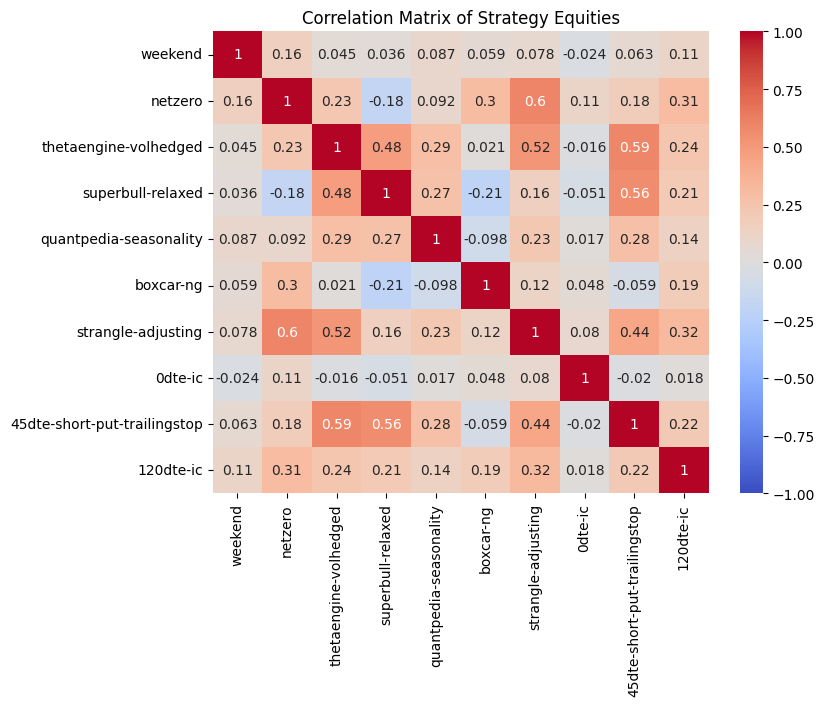

In [ ]:
log_rets = np.log(merged_df).diff().dropna()
correlation_matrix = log_rets.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Strategy Equities')
plt.show()


## Equal weighting portfolio

In [ ]:
total_capital = 100000
num_assets = len(merged_df.columns)
equal_allocation = total_capital / num_assets
portfolio = equal_allocation * merged_df


summed = pd.DataFrame(portfolio)
summed["sum"] = summed.sum(axis=1)


display_tearsheet(Q_API_INSTANCE, API_KEY, summed, 'sum')

## Grid search using Equal Weights

In [ ]:
import itertools
strategies = list(run_ids.keys())
all_combinations = list(itertools.chain.from_iterable(itertools.combinations(strategies, r) for r in range(1, len(strategies) + 1)))

print(f"There are {len(all_combinations)} combos")
results = {}

total_capital = 100000
for i, combo in enumerate(all_combinations):
  num_assets = len(combo)
  equal_allocation = total_capital / num_assets
  portfolio = equal_allocation * merged_df[list(combo)]

  summed = pd.DataFrame(portfolio)
  summed["sum"] = summed.sum(axis=1)
  metrics = get_metrics(Q_API_INSTANCE, API_KEY, summed, 'sum')
  strategy_perf = metrics['Strategy']

  print(f"#{i} / {len(all_combinations)} {combo}: {strategy_perf['Sharpe']} sharpe")
  results[combo] = strategy_perf


There are 1023 combos
#0 / 1023 ('weekend',): 1.62 sharpe
#1 / 1023 ('netzero',): 0.59 sharpe
#2 / 1023 ('thetaengine-volhedged',): 1.4 sharpe
#3 / 1023 ('superbull-relaxed',): 0.84 sharpe
#4 / 1023 ('quantpedia-seasonality',): 2.03 sharpe
#5 / 1023 ('boxcar-ng',): 1.1 sharpe
#6 / 1023 ('strangle-adjusting',): 0.9 sharpe
#7 / 1023 ('0dte-ic',): 0.78 sharpe
#8 / 1023 ('45dte-short-put-trailingstop',): 1.66 sharpe
#9 / 1023 ('120dte-ic',): 0.59 sharpe
#10 / 1023 ('weekend', 'netzero'): 1.06 sharpe
#11 / 1023 ('weekend', 'thetaengine-volhedged'): 1.51 sharpe
#12 / 1023 ('weekend', 'superbull-relaxed'): 1.37 sharpe
#13 / 1023 ('weekend', 'quantpedia-seasonality'): 2.31 sharpe
#14 / 1023 ('weekend', 'boxcar-ng'): 1.04 sharpe
#15 / 1023 ('weekend', 'strangle-adjusting'): 1.01 sharpe
#16 / 1023 ('weekend', '0dte-ic'): 1.77 sharpe
#17 / 1023 ('weekend', '45dte-short-put-trailingstop'): 1.94 sharpe
#18 / 1023 ('weekend', '120dte-ic'): 0.79 sharpe
#19 / 1023 ('netzero', 'thetaengine-volhedged'):

## Show Grid Search results

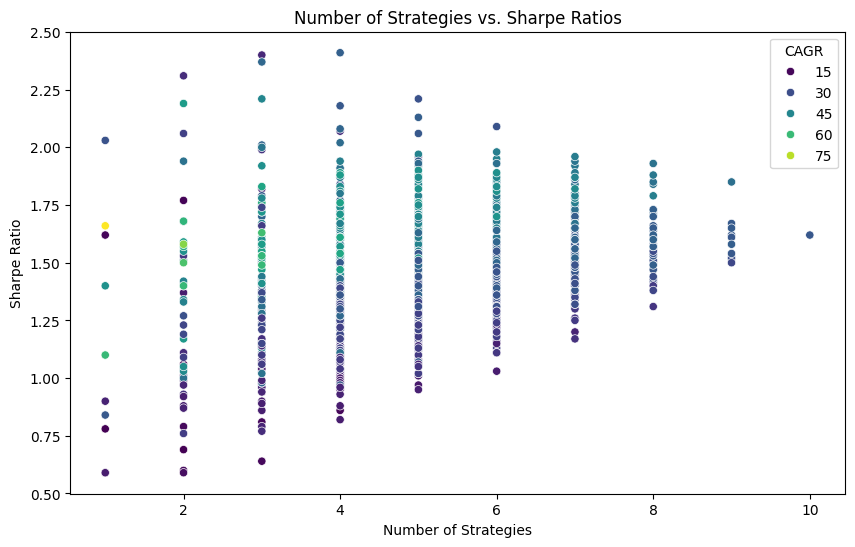

In [ ]:
old_style = {k: v['Sharpe'] for k,v in results.items()}
portfolio_to_sharpe = []
for strategies, metrics in results.items():
  portfolio_to_sharpe.append({
      'Num_Strategies': len(strategies),
      'Sharpe': metrics['Sharpe'],
      'MaxDD': metrics['MaxDrawdown'],
      'CAGR': metrics['CAGRPercent']})

portfolio_to_sharpe_df = pd.DataFrame(portfolio_to_sharpe)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Num_Strategies', y='Sharpe', hue='CAGR', palette='viridis', data=portfolio_to_sharpe_df)

plt.title('Number of Strategies vs. Sharpe Ratios')
plt.xlabel('Number of Strategies')
plt.ylabel('Sharpe Ratio')
plt.show()

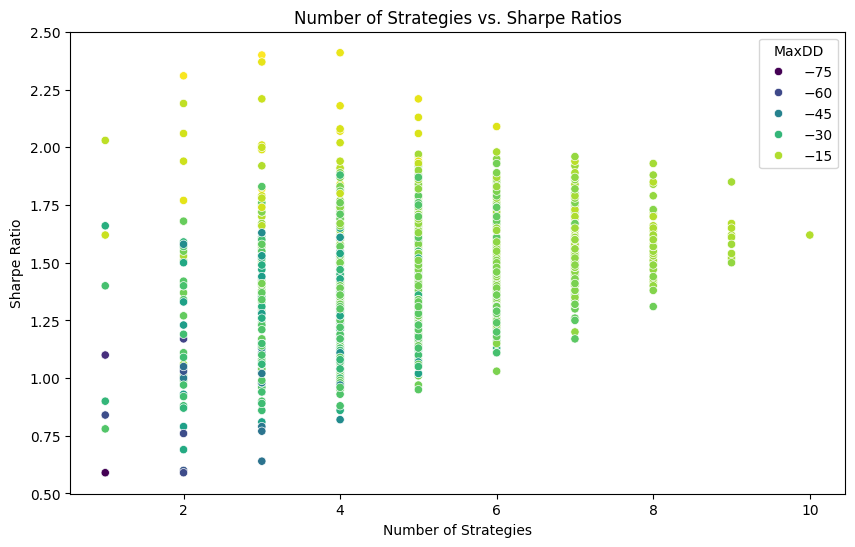

In [ ]:
old_style = {k: v['Sharpe'] for k,v in results.items()}
portfolio_to_sharpe = []
for strategies, metrics in results.items():
  portfolio_to_sharpe.append({
      'Num_Strategies': len(strategies),
      'Sharpe': metrics['Sharpe'],
      'MaxDD': metrics['MaxDrawdown'],
      'CAGR': metrics['CAGRPercent']})

portfolio_to_sharpe_df = pd.DataFrame(portfolio_to_sharpe)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Num_Strategies', y='Sharpe', hue='MaxDD', palette='viridis', data=portfolio_to_sharpe_df)

plt.title('Number of Strategies vs. Sharpe Ratios')
plt.xlabel('Number of Strategies')
plt.ylabel('Sharpe Ratio')
plt.show()

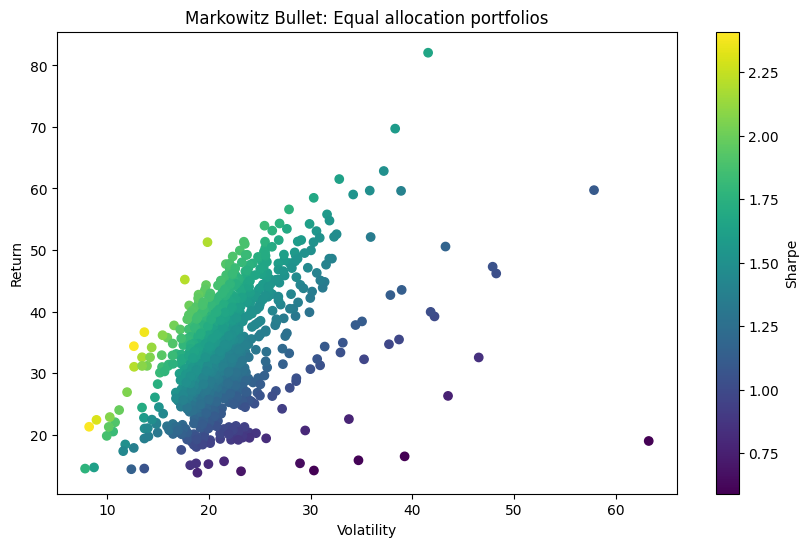

In [ ]:
results_df = pd.DataFrame.from_dict(results).T

plt.figure(figsize=(10, 6))
sc = plt.scatter(x=results_df['AnnualVolatility'], y=results_df['CAGRPercent'],
            c=results_df['Sharpe'], cmap='viridis', marker='o')
plt.colorbar(sc, label='Sharpe')
plt.title('Markowitz Bullet: Equal allocation portfolios')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

In [ ]:
best_from_gridsearch = {e[0]: e[1]['Sharpe'] for e in
             sorted(results.items(), key=lambda x: x[1]['Sharpe'], reverse=True)[:5]}

best_from_gridsearch

{('weekend',
  'quantpedia-seasonality',
  '0dte-ic',
  '45dte-short-put-trailingstop'): 2.41,
 ('weekend', 'quantpedia-seasonality', '0dte-ic'): 2.4,
 ('weekend', 'quantpedia-seasonality', '45dte-short-put-trailingstop'): 2.37,
 ('weekend', 'quantpedia-seasonality'): 2.31,
 ('quantpedia-seasonality', '0dte-ic', '45dte-short-put-trailingstop'): 2.21}

In [ ]:
print(results[('weekend','quantpedia-seasonality','0dte-ic','45dte-short-put-trailingstop')]['CAGRPercent'])
print(results[('weekend','quantpedia-seasonality','0dte-ic','45dte-short-put-trailingstop')]['AnnualVolatility'])

34.36
12.6


## Mean Variance Optimization using walk-forward approach

In [ ]:
top_alloc = 5
for optMode in ('MeanVarianceMaxSharpe', 'MeanVarianceMinVolatility'):
  for window in (20, 40, 60, 120, 240):
    metrics = walkforward_metrics(Q_API_INSTANCE, API_KEY, merged_df, optMode, top_alloc, window)
    print(f"walkfwd({optMode}, {window}) = Sharpe {metrics['Strategy']['Sharpe']}")

walkfwd(MeanVarianceMaxSharpe, 20) = Sharpe 1.3
walkfwd(MeanVarianceMaxSharpe, 40) = Sharpe 0.76
walkfwd(MeanVarianceMaxSharpe, 60) = Sharpe 0.72
walkfwd(MeanVarianceMaxSharpe, 120) = Sharpe 0.98
walkfwd(MeanVarianceMaxSharpe, 240) = Sharpe 1.14
walkfwd(MeanVarianceMinVolatility, 20) = Sharpe 1.87
walkfwd(MeanVarianceMinVolatility, 40) = Sharpe 1.48
walkfwd(MeanVarianceMinVolatility, 60) = Sharpe 1.78
walkfwd(MeanVarianceMinVolatility, 120) = Sharpe 1.96
walkfwd(MeanVarianceMinVolatility, 240) = Sharpe 1.88


## Show the best result

### Tearsheet

In [ ]:
walkforward_tearsheet(Q_API_INSTANCE, API_KEY, merged_df, 'MeanVarianceMinVolatility', top_alloc, 120)

### Allocation over time

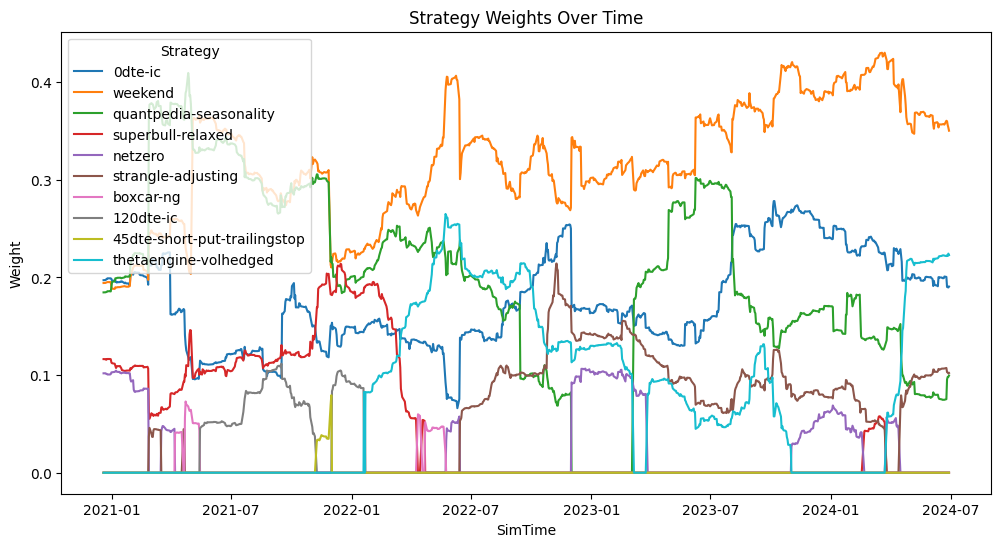

In [ ]:
def walkforward_weights(q_api_instance, api_key, df, optMode, topAlloc, window):
  df_copy = pd.DataFrame(df)
  df_copy.index.rename('DateTime', inplace=True)
  my_csv = df_copy.to_csv()
  url = f"https://{q_api_instance}/portfolio-optimizer/v1/walkforward-weights?mode={optMode}&topAlloc={topAlloc}&windowSize={window}"
  resp = http_client.post(url, data=my_csv,
                          headers = {'Content-Type': 'text/plain'})
  resp.raise_for_status()
  result_df = pd.read_csv(StringIO(resp.content.decode('utf-8')), parse_dates=True, index_col='DateTime')
  return result_df

def alloc_over_time(df, window, opt_mode):
  weights = walkforward_weights(Q_API_INSTANCE, API_KEY, merged_df, opt_mode, top_alloc, window)
  weights = weights.fillna(0)

  weights_melted = weights.reset_index().melt(id_vars='DateTime', var_name='Strategy', value_name='Weight')
  weights_pivot = weights_melted.pivot(index='DateTime', columns='Strategy', values='Weight')

  plt.figure(figsize=(12, 6))
  sns.lineplot(data=weights_melted, x='DateTime', y='Weight', hue='Strategy')
  plt.title('Strategy Weights Over Time')
  plt.xlabel('SimTime')
  plt.ylabel('Weight')
  plt.legend(title='Strategy')
  plt.show()

alloc_over_time(merged_df, 120, 'MeanVarianceMinVolatility')